In [148]:
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.tree as tree
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [64]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

In [65]:
data_raw = pd.read_csv('./data/nshap_w1_w2_w3_core_disposition.csv',
                       low_memory=False)
#Stacking
#SMOTE

## Data cleaning

In [66]:
data_raw

,ID,SAMPLETYPE,w3DISP_GRP,w3DECEASED,ID_as_string,w2DISP_GRP,w2DECEASED,w1FI_ID,w1PATH,w1VERSION,...,w3IWDESCRIBE2,w3IWDESCRIBE3,w3IWDESCRIBE4,w3IWDESCRIBE5,w3AREACOMFORT,w3AREASAFE,w3AREAAMENITIES,w3AREAPRESENCE,w3CASEDIF,_merge
0,100005,1.0,5.0,0.0,100005.0,1.0,0.0,866808.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
1,100033,1.0,1.0,0.0,100033.0,1.0,0.0,169164.0,3.0,3.0,...,1.0,1.0,2.0,1.0,1.0,1.0,2.0,5.0,4.0,3
2,100067,1.0,1.0,0.0,100067.0,NaN,NaN,NaN,NaN,NaN,...,3.0,3.0,2.0,3.0,2.0,2.0,3.0,3.0,3.0,3
3,100080,1.0,1.0,0.0,100080.0,1.0,0.0,281481.0,6.0,2.0,...,1.0,1.0,5.0,1.0,1.0,1.0,2.0,3.0,4.0,3
4,100149,1.0,1.0,0.0,100149.0,NaN,NaN,NaN,NaN,NaN,...,3.0,2.0,2.0,2.0,1.0,1.0,1.0,3.0,4.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6064,199846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,1.0,1.0,2.0,1.0,1.0,2.0,5.0,4.0,2
6065,199898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,4.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,2
6066,199931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-3.0,-3.0,-3.0,-3.0,1.0,1.0,1.0,5.0,2.0,2
6067,199954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,4.0,1.0,1.0,1.0,3.0,5.0,1.0,2


In [67]:
# Since the data contains original cohort and follow-up cohort, we need to filter out the follow-up cohort
print("Total observations: {}".format(len(data_raw)))
data_w1 = data_raw[~data_raw['w1WEIGHT_ADJ'].isnull()]
print("Removed follow-up {} respondents without W1 observations".format(len(data_raw) - len(data_w1)))
data_decease = data_w1[data_w1.notnull()].copy()
data_decease['deceased'] = data_decease['w3DECEASED']
data_decease.loc[data_decease['deceased'] == -9, ['deceased']] = np.nan
data_decease['deceased'].fillna(data_decease['w2DECEASED'], inplace=True)
data_decease.loc[data_decease['deceased'] == -9, ['deceased']] = np.nan
data_complete = data_decease[data_decease['deceased'].notnull()]
print("Removed follow-up {} respondents without disposition statuses".format(len(data_w1) - len(data_complete)))
print("Sample frame has {} respondents".format(len(data_complete)))


Total observations: 6069
Removed follow-up 3064 respondents without W1 observations
Removed follow-up 10 respondents without disposition statuses
Sample frame has 2995 respondents


In [68]:
data_complete['deceased'].value_counts()

0.0    2102
1.0     893
Name: deceased, dtype: int64

In [69]:
data = data_complete[['ID', 'deceased', 'w1AGE', 'w1SYSTOLIC_MEAN',
                      'w1BMI', 'w1HBA1C', 'w1CRP', 'w1DHEA_1', 'w1DHEA_2',
                      'w1SMOKECIG', 'w1ALCOHOL', 'w1PHYSACT', 'w1HRSSLEEP',
                      'w1EDUC', 'w1HSASSETS_RECODE', 'w1MARITLST', 'w1ETHGRP',
                      'w1GENDER',
                      'w1PHYSHLTH', 'w1MNTLHLTH', 'w1CONDITNS_3', 'w1WALKBLK']]

In [70]:
# Preprocessing binary variables
cat_col = ['ID', 'deceased', 'w1SMOKECIG', 'w1ALCOHOL', 'w1MARITLST',
           'w1ETHGRP', 'w1GENDER',
           'w1CONDITNS_3']
data_cat = data[data[cat_col].notnull()].copy()[cat_col]
for col in cat_col:
    data_cat[col] = data_cat[col].astype('category')
data_cat['w1married'] = np.where(data_cat['w1MARITLST'] == 'Married', 1, 0)
data_cat['w1raceblk'] = np.where(data_cat['w1ETHGRP'] == 'Married', 1, 0)
data_cat.drop('w1MARITLST', axis=1, inplace=True)
data_cat.drop('w1ETHGRP', axis=1, inplace=True)

In [71]:
# Preprocessing ordinal variables
ord_col = ['w1PHYSACT', 'w1EDUC', 'w1HSASSETS_RECODE',
           'w1PHYSHLTH', 'w1MNTLHLTH', 'w1WALKBLK']
data_ord = data[data[ord_col].notnull()].copy()[ord_col]
data_ord[data_ord < 0] = np.nan
data_ord.fillna(data_ord.mean(), inplace=True)

In [72]:
# Preprocessing continuous variables
con_col = ['w1AGE', 'w1SYSTOLIC_MEAN', 'w1BMI', 'w1HBA1C',
           'w1CRP', 'w1DHEA_1', 'w1DHEA_2', 'w1HRSSLEEP']
data_con = data[data[con_col].notnull()].copy()[con_col]
for col in con_col:
    data_con[col] = pd.to_numeric(data_con[col], errors='coerce')
data_con['w1dhea_mean'] = data_con[['w1DHEA_1', 'w1DHEA_2']].mean(axis=1)
data_con = data_con.drop(['w1DHEA_1', 'w1DHEA_2'], axis=1)
data_con[data_con < 0] = np.nan
data_con.fillna(data_con.mean(), inplace=True)
data_con.describe()

,w1AGE,w1SYSTOLIC_MEAN,w1BMI,w1HBA1C,w1CRP,w1HRSSLEEP,w1dhea_mean
count,2995.000000,2995.000000,2995.000000,2995.000000,2995.000000,2995.000000,2995.000000
mean,69.307513,137.138234,29.095167,6.097641,3.194580,6.888366,52.921454
std,7.857698,20.306078,6.078190,0.782456,4.848129,1.381350,109.835482
min,57.000000,78.000000,14.063041,4.200000,0.000000,1.000000,1.510000
25%,62.000000,122.500000,25.101870,5.700000,1.053500,6.000000,22.252500
50%,69.000000,135.666672,28.793165,6.097641,3.194580,7.000000,46.205000
75%,76.000000,149.000000,31.773318,6.097641,3.194580,8.000000,53.247500
max,85.000000,233.000000,75.600655,14.200000,100.000000,13.000000,5000.000000


In [73]:
data = pd.concat([data_cat, data_ord, data_con], axis=1)
data_nona = data.dropna()
print("Removed {} respondents with missing values in categorical variables".format(len(data) - len(data_nona)))

Removed 0 respondents with missing values in categorical variables


In [75]:
data_nona.to_csv("./data/save_df.csv")

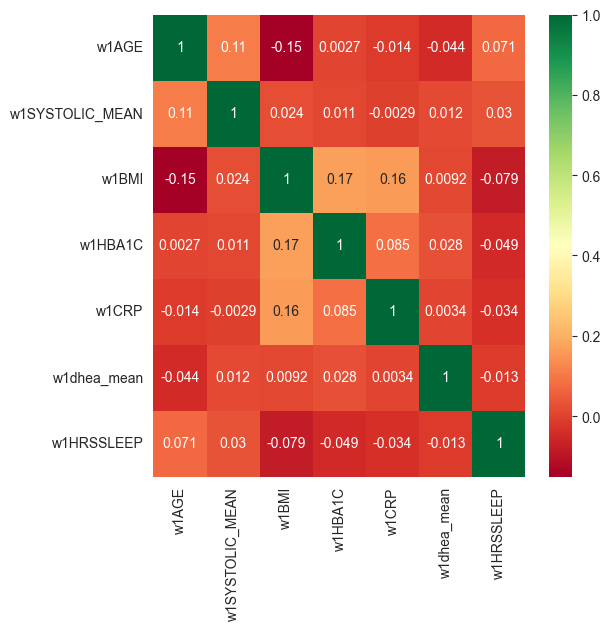

In [76]:
_, ax = plt.subplots(figsize=(6, 6))
columns = ['w1AGE', 'w1SYSTOLIC_MEAN', 'w1BMI', 'w1HBA1C',
           'w1CRP', 'w1dhea_mean', 'w1HRSSLEEP']
sns.heatmap(data[columns].corr(), annot=True, cmap='RdYlGn', ax=ax);

## Decision Tree

In [135]:
data_nona=pd.read_csv('./data/save_df.csv')

In [136]:

data_x = data_nona[['w1AGE', 'w1SYSTOLIC_MEAN',
                    'w1BMI', 'w1HBA1C', 'w1CRP', 'w1dhea_mean',
                    'w1SMOKECIG', 'w1ALCOHOL', 'w1PHYSACT', 'w1HRSSLEEP',
                    'w1EDUC', 'w1HSASSETS_RECODE', 'w1married', 'w1raceblk',
                    'w1GENDER',
                    'w1PHYSHLTH', 'w1MNTLHLTH', 'w1CONDITNS_3', 'w1WALKBLK']]
predictor_names = ['Age', 'Systolic BP', 'BMI', 'HbA1c', 'CRP', 'DHEA',
                   'smoker', 'alcohol', 'physical activity', 'sleep',
                   'education', 'wealth', 'married', 'black race', 'gender',
                   'physical self-rated health', 'mental self-rated health',
                   'chronic conditions', 'walking 1 block']
data_y = data_nona[['deceased']]

# Then split into 60% training, 20% validation, and 20% testing
X_train_v, X_test, y_train_v, y_test = train_test_split(data_x, data_y,
                                                        test_size=0.2,
                                                        random_state=42)
# 0.25 x 0.8 = 0.2
X_train, X_val, y_train, y_val = train_test_split(X_train_v,
                                                  y_train_v,
                                                  test_size=0.25,
                                                  random_state=1)

In [137]:
# BOTH PRE-PRUNING AND POST_PRUNING (PYTHON PACKAGES TO AUTOMATE THIS PROCESS)
DT_clf = tree.DecisionTreeClassifier(random_state=42, criterion="entropy",
                                     min_impurity_decrease=0.01)
DT_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=0.01,
                       random_state=42)

In [80]:
# save tree to iris.pdf
dot_data = tree.export_graphviz(DT_clf, out_file=None,
                                feature_names=predictor_names,
                                class_names=['alive', 'deceased'])
graph = graphviz.Source(dot_data)
graph.render("dt_nshap")

'dt_nshap.pdf'

In [81]:
DT_clf.score(X_test, y_test)

0.7378964941569283

## Random Forest

In [162]:
RF_clf = RandomForestClassifier(max_depth=2, random_state=0)
RF_clf.fit(X_train, y_train)

/var/folders/zw/thvqht1n2q9ggd09wgsw76th0000gn/T/ipykernel_4787/3965726035.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=2, random_state=0)

In [163]:
RF_clf.score(X_test, y_test)

/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.7145242070116862

In [164]:
len(RF_clf.estimators_)

100

In [165]:
dot_data = tree.export_graphviz(RF_clf.estimators_[0], out_file=None,
                                filled=True, rounded=True,
                                special_characters=True,
                                feature_names=predictor_names,
                                class_names=['Alive', 'Deceased'])
graph = graphviz.Source(dot_data)
graph.render("rf0_nshap")

'rf0_nshap.pdf'

In [166]:
dot_data = tree.export_graphviz(RF_clf.estimators_[1], out_file=None,
                                filled=True, rounded=True,
                                special_characters=True,
                                feature_names=predictor_names,
                                class_names=['Alive', 'Deceased'])
graph = graphviz.Source(dot_data)
graph.render("rf1_nshap")

'rf1_nshap.pdf'

## Stacking

In [177]:
clfs = [RandomForestClassifier(n_estimators=25, n_jobs=-1, criterion='gini'),
        RandomForestClassifier(n_estimators=25, n_jobs=-1, criterion='entropy'),
        ExtraTreesClassifier(n_estimators=25, n_jobs=-1, criterion='gini'),
        ExtraTreesClassifier(n_estimators=25, n_jobs=-1, criterion='entropy'),
        GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=25)]

n_folds = 8
verbose = True
shuffle = False

In [178]:
X_train_v=np.array(X_train_v)
y_train_v=np.array(y_train_v)
dataset_blend_train = np.zeros((X_train_v.shape[0], len(clfs)))
dataset_blend_test = np.zeros((X_test.shape[0], len(clfs)))
print(X_train_v.shape,y_train_v.shape)

(2396, 19) (2396, 1)


In [179]:
skf = StratifiedKFold(n_folds).split(X_train_v,y_train_v)
for j, clf in enumerate(clfs):
    print(j, clf)
    dataset_blend_test_j = np.zeros((X_test.shape[0], n_folds))
    for i, (train, test) in enumerate(skf):
        print("Fold", i)
        X_train = X_train_v[train]
        y_train = y_train_v[train]
        X_test_temp = X_train_v[test]
        y_test_temp = y_train_v[test]
        clf.fit(X_train, y_train)
        y_submission = clf.predict_proba(X_test_temp)[:, 1]
        dataset_blend_train[test, j] = y_submission
        dataset_blend_test_j[:, i] = clf.predict_proba(X_test)[:, 1]
    dataset_blend_test[:, j] = dataset_blend_test_j.mean(1)

0 RandomForestClassifier(n_estimators=25, n_jobs=-1)
Fold 0
Fold 1
Fold 2
Fold 3


/var/folders/zw/thvqht1n2q9ggd09wgsw76th0000gn/T/ipykernel_4787/2262908299.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)
/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/var/folders/zw/thvqht1n2q9ggd09wgsw76th0000gn/T/ipykernel_4787/2262908299.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)
/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/var/folders/zw/thvqht1n2q9ggd09wgsw76th0000gn/T/ipykernel_4787/22629082

Fold 4
Fold 5
Fold 6
Fold 7
1 RandomForestClassifier(criterion='entropy', n_estimators=25, n_jobs=-1)
2 ExtraTreesClassifier(n_estimators=25, n_jobs=-1)
3 ExtraTreesClassifier(criterion='entropy', n_estimators=25, n_jobs=-1)
4 GradientBoostingClassifier(learning_rate=0.05, max_depth=6, n_estimators=25,
                           subsample=0.5)


/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [180]:
dataset_blend_train

array([[0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.64, 0.  , 0.  , 0.  , 0.  ],
       [0.64, 0.  , 0.  , 0.  , 0.  ],
       ...,
       [0.52, 0.  , 0.  , 0.  , 0.  ],
       [0.36, 0.  , 0.  , 0.  , 0.  ],
       [0.24, 0.  , 0.  , 0.  , 0.  ]])

In [181]:
clf = LogisticRegression()
clf.fit(dataset_blend_train, y_train_v)
y_submission = clf.predict_proba(dataset_blend_test)[:, 1]
#y_submission = (y_submission - y_submission.min()) / (y_submission.max() - y_submission.min())
y_submission

/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.59375403, 0.31775206, 0.14393427, 0.31326156, 0.25033742,
       0.54794404, 0.22765975, 0.18363896, 0.21336737, 0.38883232,
       0.22043049, 0.23133653, 0.3088058 , 0.43922922, 0.35485271,
       0.32683494, 0.10758191, 0.56845249, 0.26626798, 0.28282985,
       0.45464723, 0.19643727, 0.18054221, 0.24261424, 0.49610878,
       0.11371911, 0.12237497, 0.62346128, 0.10560182, 0.22402438,
       0.10173791, 0.25822262, 0.21687814, 0.59875963, 0.26626798,
       0.16281401, 0.48571597, 0.13641742, 0.13888559, 0.22043049,
       0.50650496, 0.15722472, 0.35962719, 0.12691193, 0.57862383,
       0.38390255, 0.32227672, 0.40375498, 0.56334453, 0.66164011,
       0.12237497, 0.12015927, 0.12237497, 0.28282985, 0.16281401,
       0.22402438, 0.24645547, 0.50650496, 0.1997402 , 0.59375403,
       0.18363896, 0.45464723, 0.12462575, 0.54278857, 0.43411435,
       0.17447115, 0.43411435, 0.18054221, 0.60870835, 0.31775206,
       0.56845249, 0.54278857, 0.21687814, 0.09799988, 0.17149

In [150]:
y_test

,deceased
1374,0.0
2110,0.0
321,0.0
2097,1.0
1578,0.0
...,...
2337,0.0
1192,0.0
226,1.0
1911,1.0


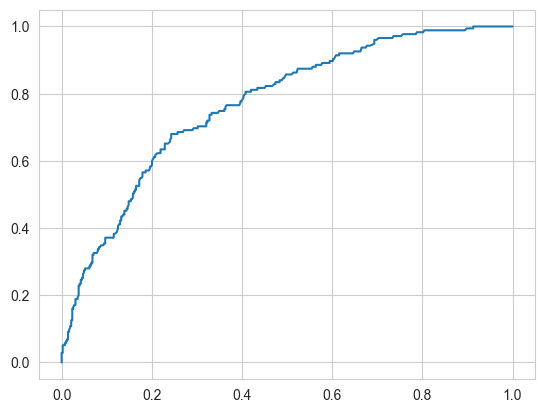

In [155]:
fpr,tpr,thr=metrics.roc_curve(y_test,y_submission)
plt.plot(fpr,tpr)

In [154]:
metrics.roc_auc_score(y_test,y_submission)

0.7701212938005391

In [157]:
thre=thr[np.argmax(np.array(tpr)-np.array(fpr))]
thre

0.35121892629632195

In [182]:
thre=0.5
y_pred=[ int(y>thre) for y in y_submission ]
acc=metrics.accuracy_score(y_pred,y_test)
acc

0.7579298831385642